In [1]:
import random
from datetime import datetime
from typing import List, Optional
from typing import Union

import numpy as np
import torch
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image as PILImage
from torch.utils.data import DataLoader

import pyml
from diffjpeg import DiffJPEG
from models import DiscriminatorPixelMse, DiscriminatorVggMse, RandomShiftCrop

In [2]:
torch.cuda.is_available()

True

In [3]:
dataset = pyml.ImagesDataset.from_dirs_recursive(roots=["datasets/flowers102processed"], channels_order='chw')
batch_size = 1
b_m = batch_size / 8

if torch.cuda.is_available():
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, pin_memory_device='cuda')
else:
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
srgan256_v0 = "/mnt/evo1gb/datasets/2023/srgan256_v0"
srgan256_v1 = "/mnt/evo1gb/datasets/2023/srgan256_v1"

squares_v0 = pyml.ImagesDataset.from_dirs_recursive([srgan256_v0], shuffle_seed=12, channels_order="chw")
squares_v1 = pyml.ImagesDataset.from_dirs_recursive([srgan256_v1], shuffle_seed=12, channels_order="chw")
squares_all = pyml.ImagesDataset.from_dirs_recursive([srgan256_v0, srgan256_v1], shuffle_seed=12, channels_order="chw")

data_loader_test = DataLoader(squares_v0, batch_size=batch_size, pin_memory=True, pin_memory_device='cuda')
data_loader_v1 = DataLoader(squares_v1, batch_size=batch_size, pin_memory=True, pin_memory_device='cuda')
data_loader_all = DataLoader(squares_all, batch_size=batch_size, shuffle=True, pin_memory=True,
                             pin_memory_device='cuda')

len(data_loader_test), len(data_loader_all)

(234252, 378533)

In [5]:
class RandomJPEG(nn.Module):
    def __init__(self, size: int, qualities: List[int], seed: int = 12):
        super(RandomJPEG, self).__init__()
        self.jpegers = nn.ParameterList([DiffJPEG(height=size, width=size, differentiable=False, quality=q) for q in qualities])
        self.dummy = nn.Parameter(torch.zeros(size=[1]))
        self.random = random.Random(seed)

    def __call__(self, x: torch.Tensor, jpeger_no: Optional[int] = None):
        if jpeger_no is None:
            jpeger = self.random.choice(self.jpegers)
        else:
            jpeger = self.jpegers[jpeger_no]

        return jpeger(x.to(self.dummy.device)).to(x.device)


In [6]:
class DenseResidualBlock(nn.Module):
    def __init__(self, channels, res_scale=0.2, layers: int = 5):
        super(DenseResidualBlock, self).__init__()
        self.res_scale = res_scale

        blocks = []
        for i in range(1, layers):
            blocks.append(nn.Sequential(
                nn.Conv2d(i * channels, channels, kernel_size=3, padding='same', bias=True),
                nn.LeakyReLU(0.1)
            ))

        self.blocks = torch.nn.ParameterList(blocks)
        self.last_conv = nn.Conv2d(layers * channels, channels, kernel_size=3, padding='same', bias=True)

    def forward(self, x):
        inputs = x
        for block in self.blocks:
            out = block(inputs)
            inputs = torch.cat([inputs, out], 1)

        return x + self.last_conv(inputs) * self.res_scale


class ResidualInResidualDenseBlock(nn.Module):
    def __init__(self, filters, res_scale=0.2, dr_layers: int = 5):
        super(ResidualInResidualDenseBlock, self).__init__()
        self.res_scale = res_scale
        self.dense_blocks = nn.Sequential(
            DenseResidualBlock(filters, layers=dr_layers),
            DenseResidualBlock(filters, layers=dr_layers),
            DenseResidualBlock(filters, layers=dr_layers)
        )

    def forward(self, x):
        return x + self.dense_blocks(x) * self.res_scale


class GeneratorRRDBx2(nn.Module):
    def __init__(self, channels: int = 64, num_res_blocks=16):
        super(GeneratorRRDBx2, self).__init__()
        
        upscale = 2
        
        self.layers = nn.Sequential(
            nn.Conv2d(3, channels, kernel_size=5, padding='same'),
            
            *[ResidualInResidualDenseBlock(channels, dr_layers=3) for _ in range(num_res_blocks)],
            # RRDB much more heavy-weight than other layers

            nn.Conv2d(channels, channels * 2, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.Conv2d(channels * 2, 64 * upscale ** 2, kernel_size=1, padding='same'),
            nn.LeakyReLU(0.1),
            nn.PixelShuffle(upscale_factor=upscale),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),  
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 3, kernel_size=3, padding='same'),
        )

    def forward(self, x):
        return self.layers(x)

In [7]:
class DiscriminatorDilationNetwork(nn.Module):
    def __init__(self,
                 generator_weight: float,
                 mid_channels: int):
        super(DiscriminatorDilationNetwork, self).__init__()

        self.generator_weight: float = generator_weight
        self.random_crop = RandomShiftCrop(4)

        self.layers = nn.Sequential(
            self.conv(3, mid_channels, kernel_size=5),
            self.conv(mid_channels, mid_channels, kernel_size=3),
            nn.MaxPool2d(2),

            self.conv(mid_channels, mid_channels * 2, kernel_size=3),
            self.conv(mid_channels * 2, mid_channels * 2, kernel_size=3),
            nn.MaxPool2d(2),

            self.conv(mid_channels * 2, mid_channels * 4, kernel_size=3),
            self.conv(mid_channels * 4, mid_channels * 4, kernel_size=3),
            nn.MaxPool2d(2),

            self.conv(mid_channels * 4, mid_channels * 8, kernel_size=3),
            self.dilated_conv3(mid_channels * 8, mid_channels * 8, dilation=2),
            self.dilated_conv3(mid_channels * 8, mid_channels * 8, dilation=4),
            self.conv(mid_channels * 8, mid_channels * 8, kernel_size=3),

            self.conv(mid_channels * 8, mid_channels * 16, kernel_size=1),
            self.conv(mid_channels * 16, mid_channels, kernel_size=1),
            nn.Conv2d(mid_channels, 1, kernel_size=1)
        )

        self.binary_crossentropy_with_sigmoid = torch.nn.BCEWithLogitsLoss()

    def conv(self, in_ch: int, out_ch: int, kernel_size: int = 3) -> torch.nn.Module:
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='same', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1),
        )

    def dilated_conv3(self, in_ch: int, out_ch: int, *, dilation: int) -> torch.nn.Module:
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, dilation=dilation, padding=dilation, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1),
        )

    def loss_for_discriminator(self,
                               y: torch.Tensor,
                               label: torch.Tensor) -> torch.Tensor:
        y, label = self.random_crop(y, label)

        diff = self(y) - self(label)
        # realness(label) should be >> realness(y)
        zeros = torch.zeros(size=diff.size()).to(diff.device)
        return self.binary_crossentropy_with_sigmoid(diff, zeros)

    def loss(self,
             y: torch.Tensor,
             label: torch.Tensor) -> torch.Tensor:
        if self.generator_weight == 0.0:
            return torch.zeros(size=[1], device=y.get_device())

        y, label = self.random_crop(y, label)

        pred_y = self(y)
        pred_label = self(label)
        y_more_real = pred_y > pred_label

        diff = y_more_real * 9000 + ~y_more_real * (pred_y - pred_label)
        ones = torch.ones(size=diff.size()).to(diff.device)
        return self.binary_crossentropy_with_sigmoid(diff, ones) * self.generator_weight

    def forward(self, y: torch.Tensor) -> torch.Tensor:
        y = self.layers(y)
        return y

In [8]:
class GanHelper:
    def __init__(self, data_loader: DataLoader):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.data_loader = data_loader
        scale = 2
        self.generator = GeneratorRRDBx2(channels=64, num_res_blocks=16).to(self.device)

        self.d_pixel_mse = DiscriminatorPixelMse(weight=1.0)
        self.d_vgg_mse = DiscriminatorVggMse(weight=0.0001, inpad_size=0).to(self.device)
        self.d_vgg_mse_x2 = DiscriminatorVggMse(weight=0.0001, prescale=2, inpad_size=0).to(self.device)
        self.d_baseline = DiscriminatorDilationNetwork(generator_weight=0.001, mid_channels=32).to(self.device)

        self.jpeger = RandomJPEG(size=256 // scale, qualities=[50, 70, 80, 90, 95, 99]).to(self.device)
        self.losses = []
        self.losses_print_step = 1000

    def add_loss(self, losses: List[torch.Tensor]):
        self.losses.append([loss.item() for loss in losses])
        if self.losses_print_step is not None and len(self.losses) % self.losses_print_step == 0:
            av_loss = np.average(np.array(self.losses[-self.losses_print_step:]), axis=0)
            print(f"{len(self.losses)}: {av_loss}")

    def generate_data(self):
        while True:
            for label in self.data_loader:
                yield label

    def downsample(self, x: torch.Tensor, factor: int) -> torch.Tensor:
        _, _, h, w = x.size()
        return F.interpolate(x, size=(h // factor, w // factor), mode='bilinear', antialias=True)

    def upsample(self, x: torch.Tensor, factor: int) -> torch.Tensor:
        _, _, h, w = x.size()
        return F.interpolate(x, size=(h * factor, w * factor), mode='bilinear')

    def train(self, *, steps: int, lr_g: float = 0.0, lr_d: float = 0.0):
        generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr_g)
        discriminator_optimizer = torch.optim.Adam(self.d_baseline.parameters(), lr=lr_d)

        self.generator.train()
        self.d_baseline.train()

        for step, label in zip(range(steps), self.generate_data()):
            label = label.to(self.device)
            label.requires_grad = False

            x = self.downsample(label, 2)
            x = self.jpeger(x)

            saved_y: Optional[torch.Tensor] = None

            # train generator
            if lr_g != 0.0:
                generator_optimizer.zero_grad()
                y = self.generator(x)
                saved_y = y.detach()

                g_losses = [f.loss(y, label) for f in
                            [self.d_pixel_mse, self.d_vgg_mse, self.d_vgg_mse_x2, self.d_baseline]]
                loss = sum(g_losses)
                loss.backward()
                generator_optimizer.step()
            else:
                g_losses = [torch.zeros(size=[1], device=self.device) for _ in range(4)]

            # train discriminator
            if lr_d != 0.0:
                discriminator_optimizer.zero_grad()
                y = saved_y if saved_y is not None else self.generator(x).detach()
                d_loss = self.d_baseline.loss_for_discriminator(y, label)
                d_loss.backward()
                discriminator_optimizer.step()
            else:
                d_loss = torch.zeros(size=[1], device=self.device)

            self.add_loss(g_losses + [d_loss])

    def demonstrate(self, label: Union[np.ndarray, torch.Tensor], jpeger_no: Optional[int] = None) -> PILImage:
        if isinstance(label, np.ndarray):
            if len(label.shape) == 3:
                label = label[np.newaxis]
            label = torch.from_numpy(label)
        assert isinstance(label, torch.Tensor)
        label = label.to(self.device)

        scale = 2
        self.generator.eval()
        x = self.downsample(label, scale)
        if jpeger_no is not None:
            x = self.jpeger(x, jpeger_no)

        y = self.generator(x)
        x4x = self.upsample(x, scale)

        triple = torch.cat([x4x, y, label], dim=3)
        pic = triple.cpu().detach().numpy()[0]
        pic = np.moveaxis(pic, 0, 2)
        pic = np.clip(pic, 0.0, 1.0)
        img = PILImage.fromarray((pic * 255.0).astype(np.uint8))
        return img

    def save_model(self) -> str:
        suffix = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
        torch.save(self.generator.state_dict(), f"models/espcn/generator_espcn_{suffix}.pth")
        torch.save(self.d_baseline.state_dict(), f"models/espcn/discriminator_baseline_{suffix}.pth")
        return suffix

    def load_model(self, suffix: str):
        self.generator.load_state_dict(torch.load(f"models/espcn/generator_espcn_{suffix}.pth"))
        self.d_baseline.load_state_dict(torch.load(f"models/espcn/discriminator_baseline_{suffix}.pth"))

In [9]:
gan_helper = GanHelper(data_loader_all)

/home/lgor/projects/2023/pyenv310/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [10]:
gan_helper.losses_print_step = 10
gan_helper.train(steps=100, lr_g=0.0001 * b_m, lr_d=0.0001 * b_m)

10: [3.71826671e-01 4.87578194e-02 8.72497467e-03 4.53127554e-04
 7.21226907e-01]
20: [1.27419451e-01 1.45424953e-02 9.05626428e-03 4.51289839e-04
 7.21204257e-01]
30: [1.49326402e-01 1.16002449e-02 9.22258610e-03 4.43733440e-04
 7.17360377e-01]
40: [9.50430041e-02 1.11773201e-02 9.94649667e-03 4.36356620e-04
 7.16930038e-01]
50: [6.57391253e-02 9.14271069e-03 7.85617998e-03 4.33637438e-04
 7.13921958e-01]
60: [1.97869915e-02 8.30438114e-03 6.64528670e-03 4.35549981e-04
 7.11969692e-01]
70: [1.31891326e-02 1.00113371e-02 6.58767223e-03 4.26875066e-04
 7.09177017e-01]
80: [1.77136506e-02 1.21274010e-02 1.02851614e-02 4.23546272e-04
 7.09232414e-01]
90: [1.11143179e-02 7.03591364e-03 6.06597706e-03 4.21992800e-04
 7.06244826e-01]
100: [1.64302752e-02 1.09778427e-02 9.01522948e-03 4.20088382e-04
 7.06593740e-01]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


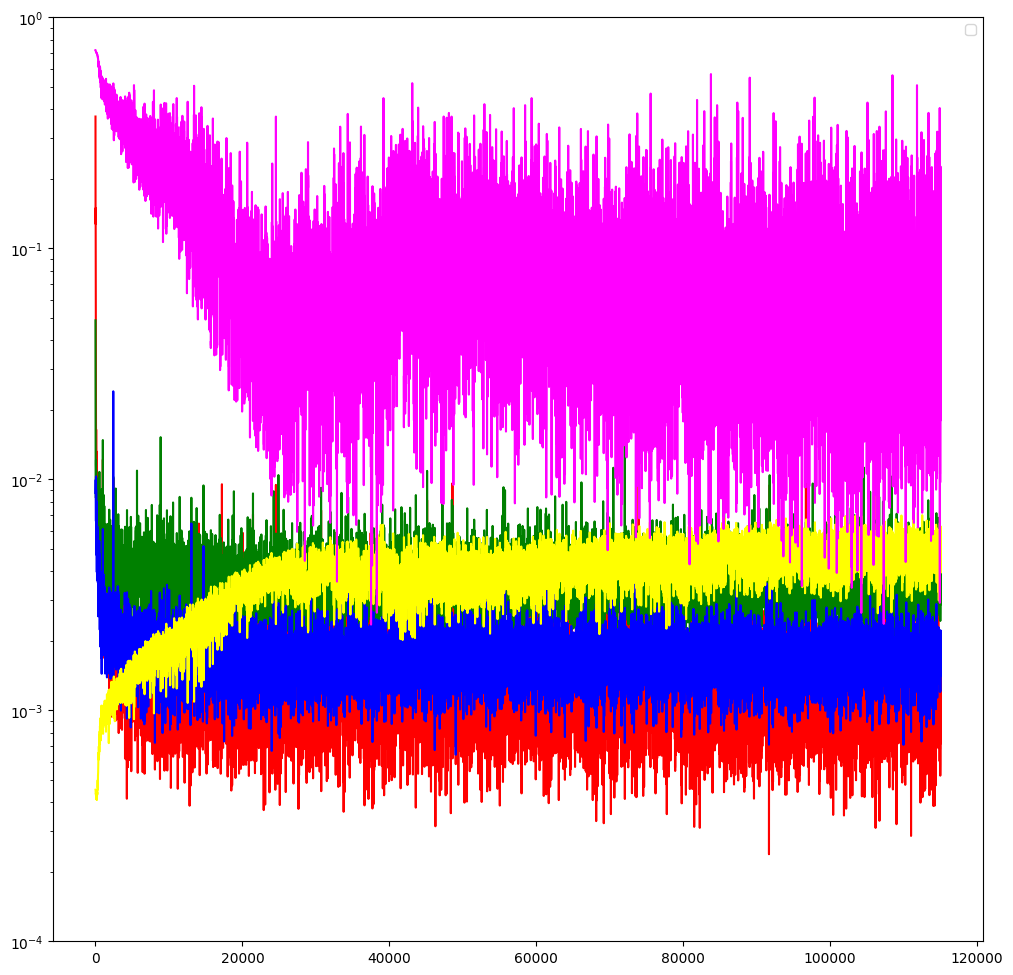

In [36]:
from matplotlib import pyplot as plt

def show_plt(av: int, y_min: float = 0.0001, y_max: float = 1.0):
    plt.rcParams['figure.figsize'] = [12, 12]
    fig, ax = plt.subplots()
    ax.set_yscale("log")
    ax.set_ylim(y_min, y_max)
    
    def my_plot(lst: List[float], av: int):
        for i, color in enumerate(["red", "green", "blue", "yellow", "magenta"]):
            arr = np.array(lst)[:, i]
            arr = arr[:arr.shape[0] // av * av]
            arr = arr.reshape(-1, av).mean(axis=1)
            ax.plot([i * av for i in range(arr.shape[0])], arr, c=color)
    
    
    my_plot(gan_helper.losses, av=av)
    
    ax.legend()
    plt.show()
    
show_plt(10)

200: [1.03337151e-02 7.69976178e-03 6.13954626e-03 4.15774567e-04
 7.00206615e-01]
300: [7.25335949e-03 6.79393417e-03 4.84964927e-03 4.40602757e-04
 6.87673663e-01]
400: [6.06508335e-03 6.66549807e-03 4.17362349e-03 5.26662311e-04
 6.60721949e-01]
500: [0.00463103 0.00556016 0.00376816 0.0006513  0.61825953]
600: [0.00514577 0.0068046  0.00363291 0.00074161 0.57813047]
700: [0.00423888 0.00528885 0.00289154 0.00081977 0.56020335]
800: [0.00406318 0.00501417 0.00276702 0.0008444  0.52536376]
900: [0.00323031 0.0053548  0.00273414 0.00091387 0.50948795]
1000: [0.00330026 0.00490517 0.00268739 0.00093143 0.48681989]
1100: [0.00365354 0.00549726 0.00287108 0.00088489 0.50536039]
1200: [0.00312545 0.00544554 0.00266468 0.00098236 0.47463425]
1300: [0.00314812 0.00560572 0.00275    0.0009777  0.46895871]
1400: [0.00249109 0.00424921 0.0021729  0.00095947 0.47818862]
1500: [0.00230411 0.00454975 0.00203842 0.00093079 0.47656582]
1600: [0.00213882 0.00460273 0.00224466 0.00100647 0.45219662]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5100: [0.00134961 0.00360636 0.00171102 0.00148793 0.29115729]


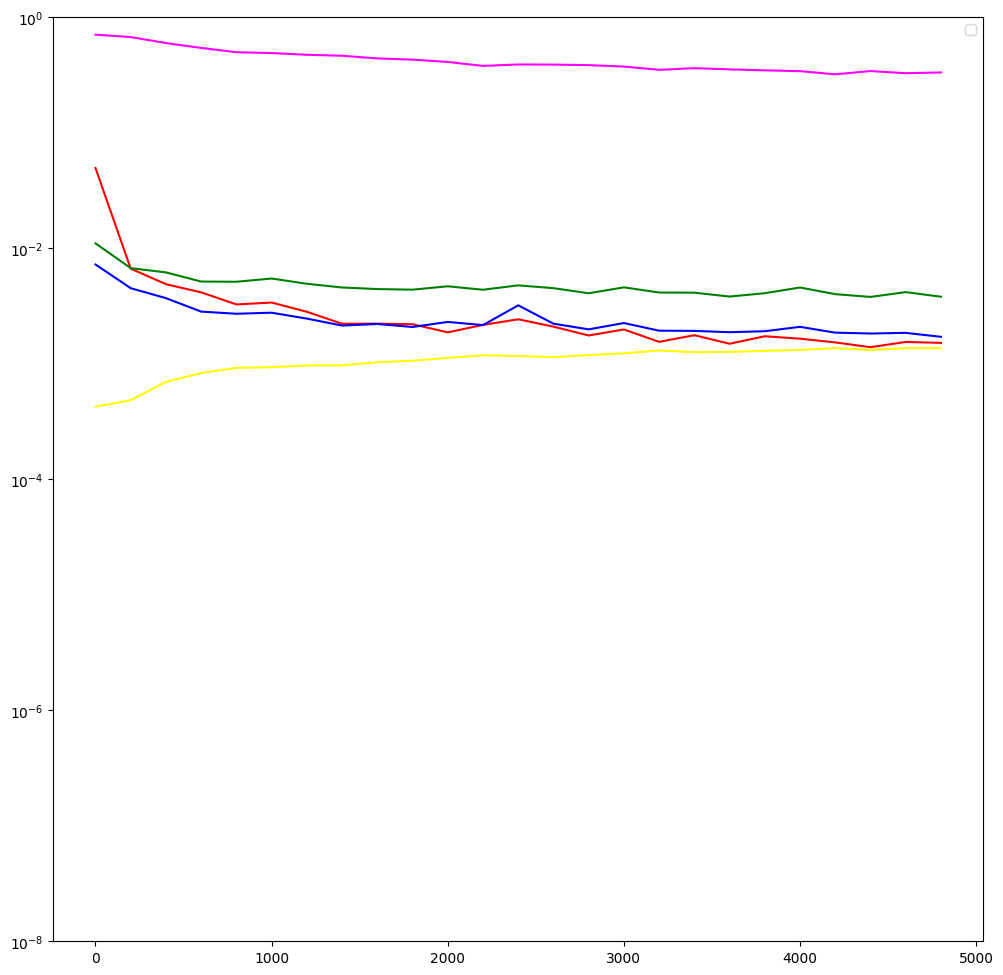

In [13]:
gan_helper.losses_print_step = 100
gan_helper.train(steps=5000, lr_g=0.0001 * b_m, lr_d=0.0001 * b_m)
show_plt(av=200)

6000: [0.00153471 0.00406849 0.00180922 0.00148341 0.29800006]
7000: [0.00150883 0.00389283 0.0017333  0.00161198 0.26895496]
8000: [0.00154892 0.00401627 0.00181117 0.00168308 0.25700288]
9000: [0.00153828 0.00399421 0.00173293 0.00179176 0.23550309]
10000: [0.00145697 0.00372837 0.00172573 0.00179056 0.2490577 ]
11000: [0.00149164 0.00389699 0.00176404 0.00187937 0.23425677]
12000: [0.00147432 0.00388155 0.00177294 0.00194729 0.22604382]
13000: [0.00128853 0.00352322 0.00167856 0.00211554 0.19657187]
14000: [0.00147763 0.00378522 0.00173897 0.0022437  0.18255681]
15000: [0.00153816 0.00375425 0.00172941 0.00232154 0.1739841 ]
16000: [0.00147492 0.00369917 0.00172204 0.0025671  0.13720725]
17000: [0.0014397  0.00365661 0.00170362 0.00273874 0.12222894]
18000: [0.00146605 0.00361702 0.00170946 0.00288006 0.10094867]
19000: [0.0013715  0.003545   0.00159926 0.00308036 0.08857207]
20000: [0.00133227 0.00350443 0.00163495 0.00332552 0.07090633]
21000: [0.00128706 0.00345734 0.00161676 0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


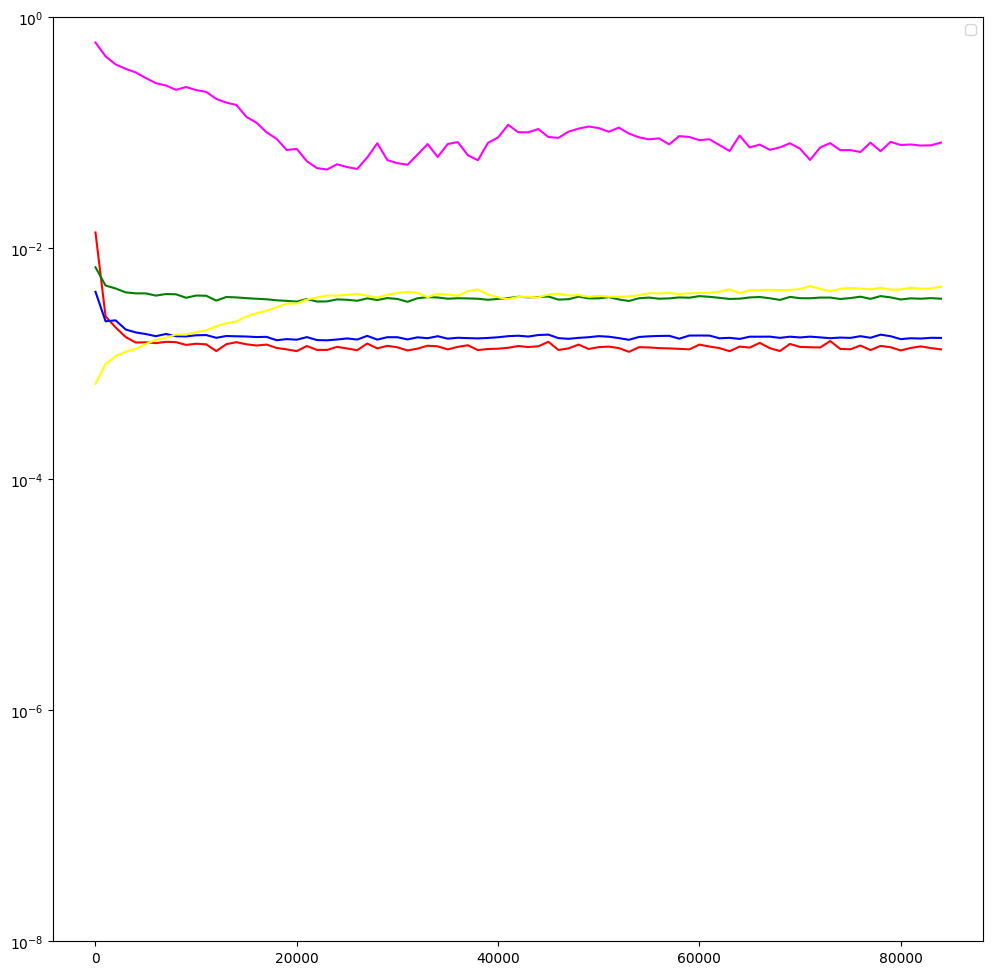

In [14]:
gan_helper.losses_print_step = 1000
gan_helper.train(steps=40000, lr_g=0.0001 * b_m, lr_d=0.0001 * b_m)
gan_helper.train(steps=40000, lr_g=0.00003 * b_m, lr_d=0.00003 * b_m)
show_plt(av=1000)

86000: [0.00138516 0.00370019 0.00162791 0.00489845 0.0565626 ]
87000: [0.00142112 0.00373224 0.00173063 0.00484637 0.06223263]
88000: [0.00135794 0.0036336  0.00165006 0.00483628 0.07534508]
89000: [0.00134028 0.00364876 0.00166704 0.00474931 0.06093345]
90000: [0.00136165 0.00365259 0.00166604 0.00472398 0.07614466]
91000: [0.00131166 0.00354728 0.00161817 0.00475885 0.07051164]
92000: [0.0014735  0.00381168 0.00173822 0.00491074 0.06753105]
93000: [0.00132721 0.00359217 0.00168159 0.00487624 0.07159962]
94000: [0.00132431 0.00359556 0.00163223 0.00490322 0.06685956]
95000: [0.00137346 0.00373657 0.0016597  0.0049557  0.06152977]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


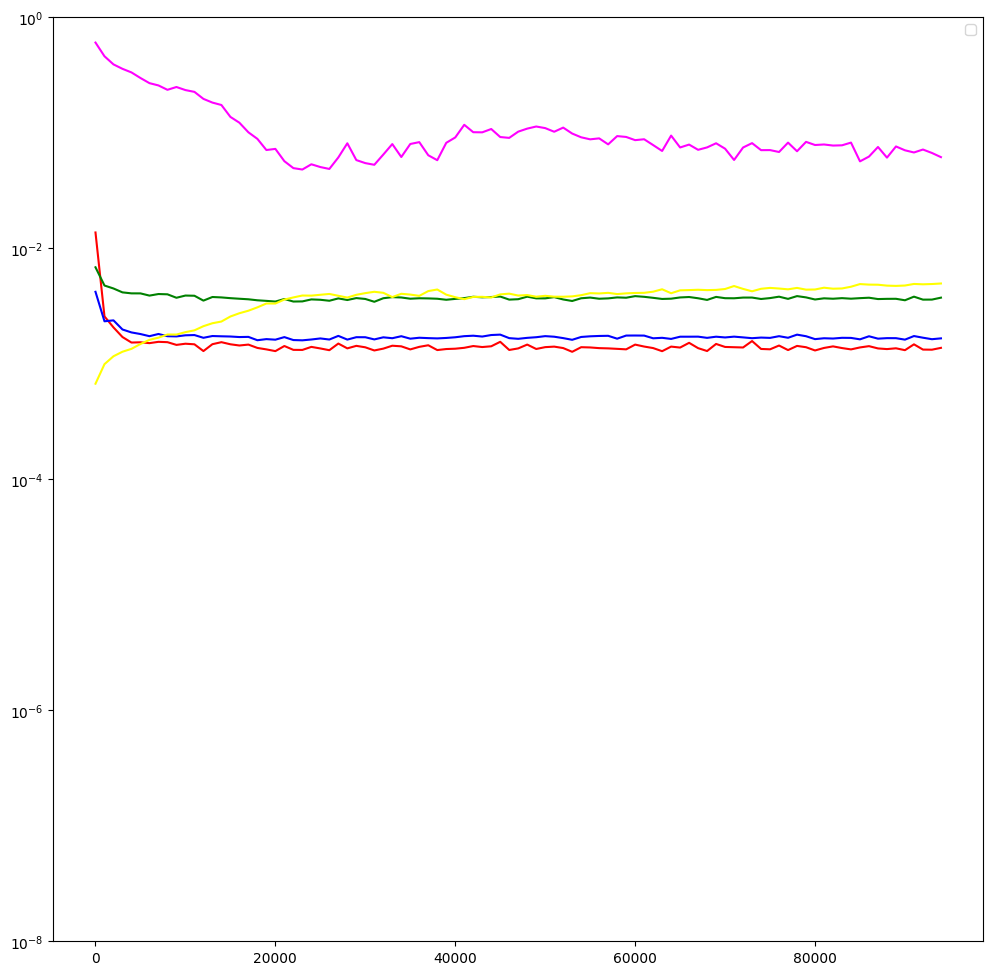

In [28]:
gan_helper.losses_print_step = 1000
gan_helper.train(steps=10000, lr_g=0.00001 * b_m, lr_d=0.00001 * b_m)
show_plt(av=1000)

In [33]:
with torch.autograd.profiler.profile(use_cuda=True, with_flops=True) as prof:
    gan_helper.train(steps=1, lr_g=0.00001 * b_m, lr_d=0.00001 * b_m)
print(prof.key_averages().table())

STAGE:2023-05-14 13:46:39 80026:80026 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-14 13:46:40 80026:80026 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W util.cpp:494] Warning: Failed to compute flops for op aten::conv2d because it requires padding, stride, and dilation values. (function computeFlops)
[W util.cpp:494] Warning: Failed to compute flops for op aten::conv2d because it requires padding, stride, and dilation values. (function computeFlops)
[W util.cpp:494] Warning: Failed to compute flops for op aten::conv2d because it requires padding, stride, and dilation values. (function computeFlops)
[W util.cpp:494] Warning: Failed to compute flops for op aten::conv2d because it requires padding, stride, and dilation values. (function computeFlops)
[W util.cpp:494] Warning: Failed to compute flops for op aten::conv2d because it requires padding, stride, and dilation values. (function computeFlops)
[W util.cpp:494] Warning: Failed to com

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         1.01%       5.503ms         1.01%       5.503ms       2.735us       4.532ms         0.73%       4.532ms       2.252us          2012            --  
                                          aten::random_         0.00%      17.000us         0.00%      17.000us       8.500us      28.000us         0.0

In [34]:
print(prof.key_averages().table(sort_by="cuda_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
autograd::engine::evaluate_function: ConvolutionBack...         1.06%       5.742ms        39.76%     216.068ms       1.005ms       1.004ms         0.16%     268.847ms       1.250ms           215            --  
                                   ConvolutionBackward0         0.86%       4.690ms        38.41%     208.757ms     970.963us     718.000us         0.1

96000: [0.00128748 0.00350987 0.00161375 0.00495016 0.07400862]
97000: [0.00144266 0.00364787 0.00169486 0.00479638 0.07649248]
98000: [0.00127996 0.00358199 0.00165707 0.0047853  0.07955537]
99000: [0.00130789 0.00351922 0.00161241 0.0046705  0.0756773 ]
100000: [0.00140969 0.0037413  0.00166081 0.00454565 0.07894681]
101000: [0.00132464 0.00361367 0.0016616  0.00471236 0.07724185]
102000: [0.00128885 0.00353758 0.00160537 0.00476512 0.0628875 ]
103000: [0.00131995 0.00357123 0.00165364 0.00490366 0.07351085]
104000: [0.00142506 0.00379636 0.00171901 0.00501009 0.06022047]
105000: [0.00130514 0.003657   0.0016538  0.00486921 0.07804759]
106000: [0.00137099 0.00357747 0.00162088 0.00476795 0.07344638]
107000: [0.00140847 0.00363041 0.00168654 0.00474186 0.0721066 ]
108000: [0.00129748 0.0036462  0.00168478 0.00488099 0.06343522]
109000: [0.00138828 0.00370675 0.00165556 0.00472746 0.07817758]
110000: [0.00150522 0.00382118 0.00177092 0.00496756 0.06468226]
111000: [0.00133379 0.0036088

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


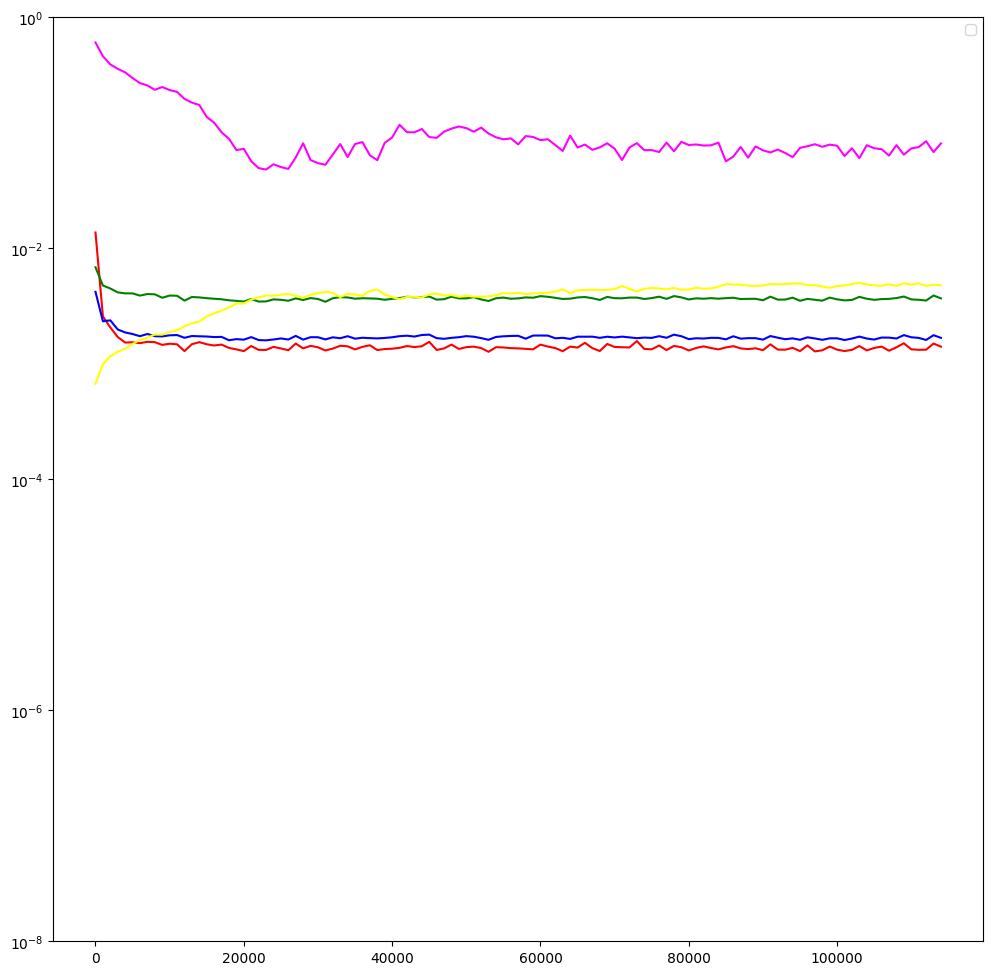

In [35]:
gan_helper.train(steps=20000, lr_g=0.00001 * b_m, lr_d=0.00001 * b_m)
show_plt(av=1000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


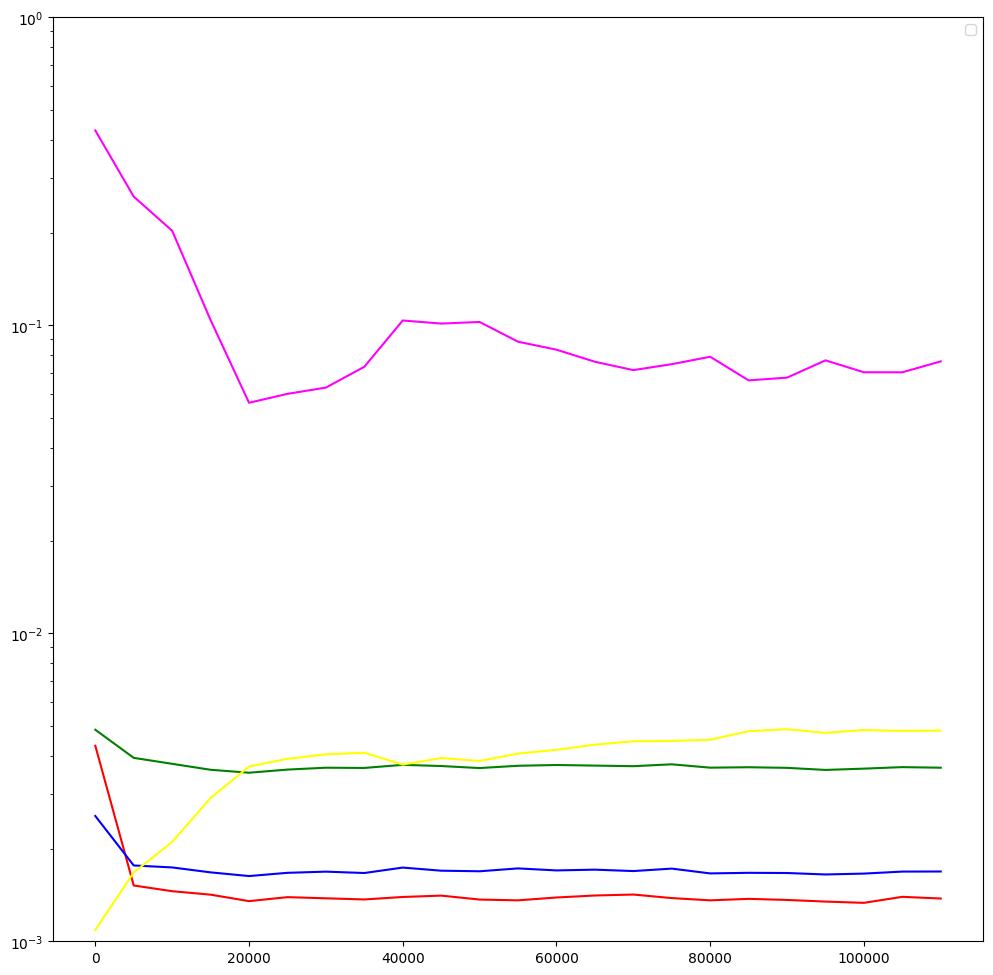

In [41]:
show_plt(av=5000, y_min=0.001, y_max=1.0)

In [43]:
gan_helper.train(steps=10000, lr_g=0.000001 * b_m, lr_d=0.00001 * b_m)

116000: [0.00147658 0.00371868 0.00170457 0.00476257 0.07460115]
117000: [0.00146045 0.00372179 0.00170757 0.00484885 0.06459325]
118000: [0.00173668 0.00390772 0.00173985 0.00495696 0.07285117]
119000: [0.00142539 0.00373334 0.0016374  0.00493488 0.0661614 ]
120000: [0.00137677 0.00359042 0.00164538 0.00487787 0.06721784]
121000: [0.00129949 0.00353937 0.00160826 0.00497247 0.06787364]
122000: [0.00139086 0.00355558 0.0015793  0.00497884 0.07350792]
123000: [0.00143981 0.00374334 0.00172557 0.00516516 0.05707728]
124000: [0.00131749 0.00356999 0.00163572 0.00519648 0.05977368]
125000: [0.00141077 0.00372991 0.00165125 0.00507514 0.06468587]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


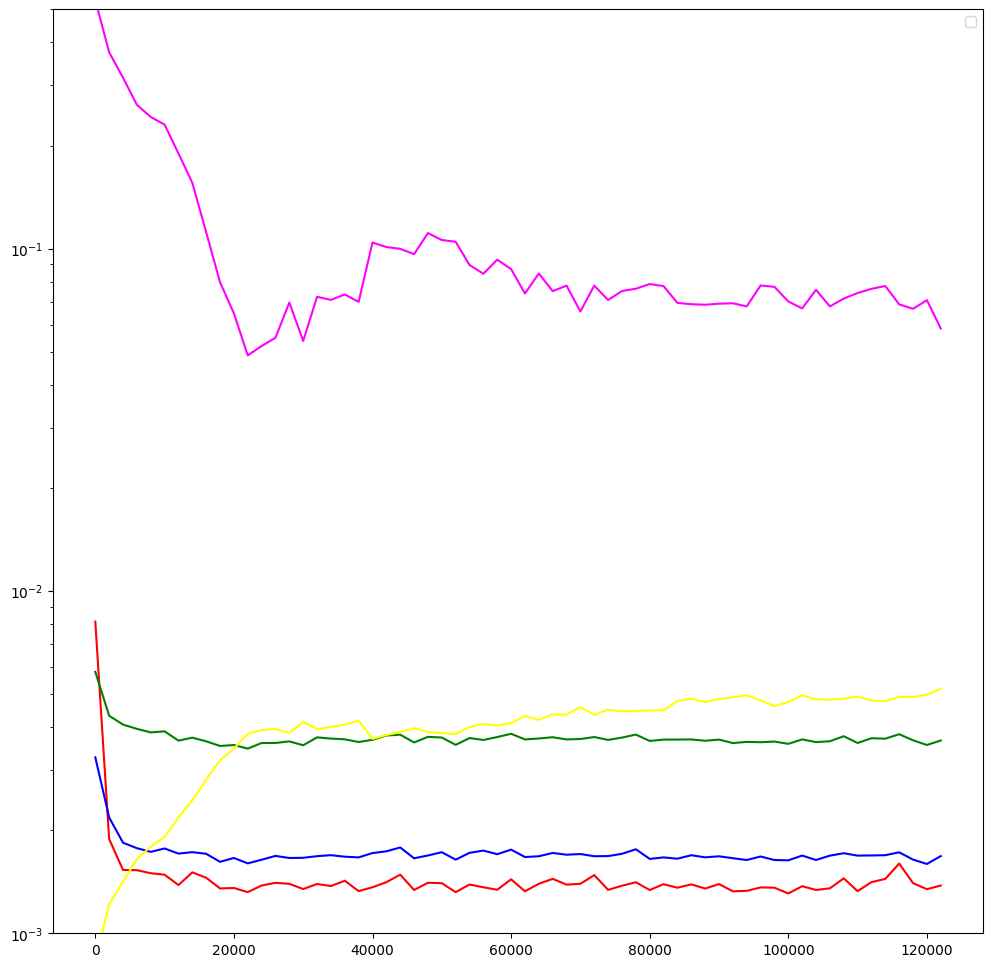

In [46]:
show_plt(av=2000, y_min=0.001, y_max=0.5)

In [49]:
model_suffix = gan_helper.save_model()
model_suffix

'2023-05-14-17-37-33'

126000: [0.00125493 0.00344954 0.00155191 0.00104641 0.04899087]
127000: [0.0013451  0.00366344 0.00161521 0.0005684  0.04368531]
128000: [0.00130532 0.00355997 0.00162206 0.00057226 0.04028475]
129000: [0.00117773 0.0034111  0.00155157 0.00058451 0.03994357]
130000: [0.00123129 0.00345665 0.0015154  0.00059014 0.03391897]
131000: [0.00129628 0.0035434  0.00154815 0.00060324 0.02847501]
132000: [0.00135316 0.00369315 0.00164392 0.00062124 0.02929747]
133000: [0.00123489 0.00343373 0.00155078 0.0006137  0.02485875]
134000: [0.00124372 0.00349245 0.00159675 0.00061872 0.02805512]
135000: [0.00120532 0.00344151 0.00154472 0.00062199 0.02418348]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


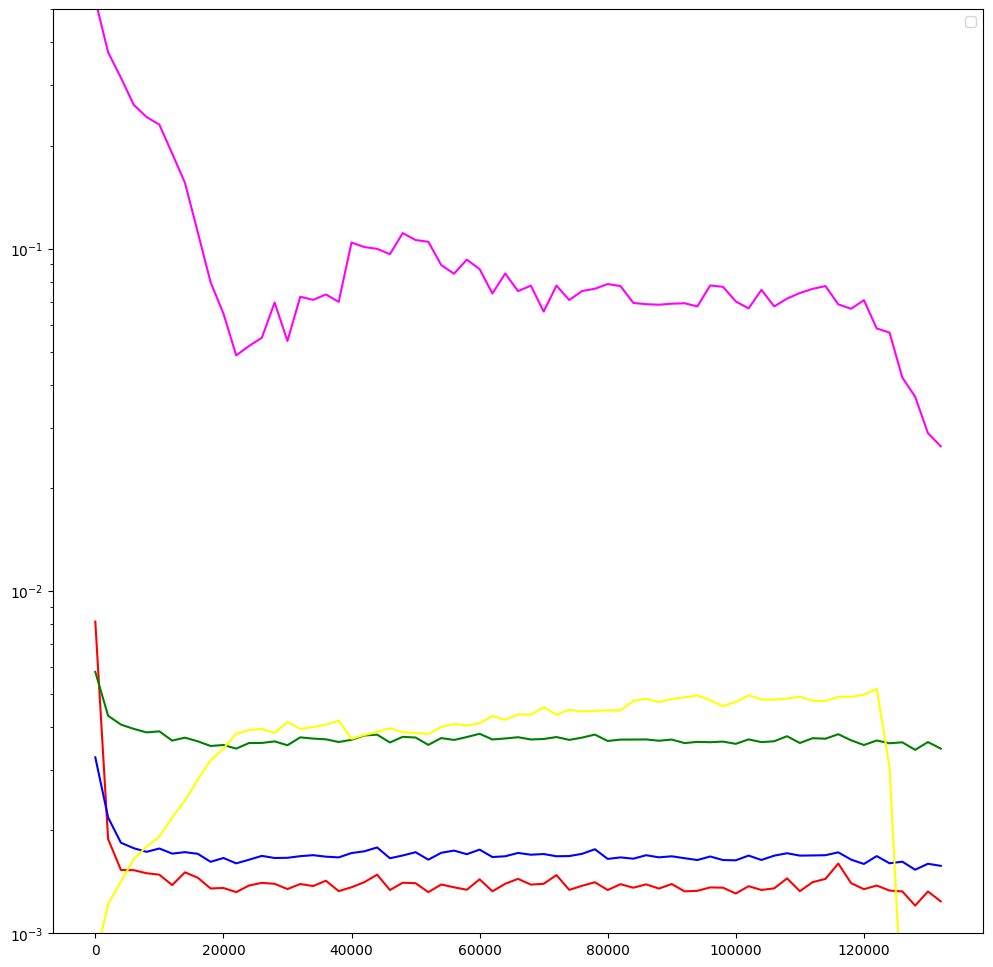

In [54]:
gan_helper.d_baseline.generator_weight = 0.0001
gan_helper.train(steps=10000, lr_g=0.000001 * b_m, lr_d=0.00001 * b_m)
show_plt(av=2000, y_min=0.001, y_max=0.5)

136000: [0.00119677 0.00337931 0.00153398 0.00169765 0.0297782 ]
137000: [0.00128316 0.00361442 0.00166275 0.00186281 0.03020744]
138000: [0.00128458 0.00356361 0.00157773 0.00184933 0.028391  ]
139000: [0.00120508 0.00347772 0.00156468 0.0018335  0.02898965]
140000: [0.00142577 0.00346599 0.00157024 0.00184773 0.03554558]
141000: [0.00127331 0.0035706  0.00159354 0.00181517 0.03234026]
142000: [0.00129431 0.00358383 0.00159329 0.00191402 0.02397393]
143000: [0.00129467 0.00339678 0.00151825 0.00184542 0.02480867]
144000: [0.00117922 0.00345733 0.00162246 0.00185414 0.02900546]
145000: [0.00127087 0.00347128 0.00157491 0.00185461 0.02878988]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


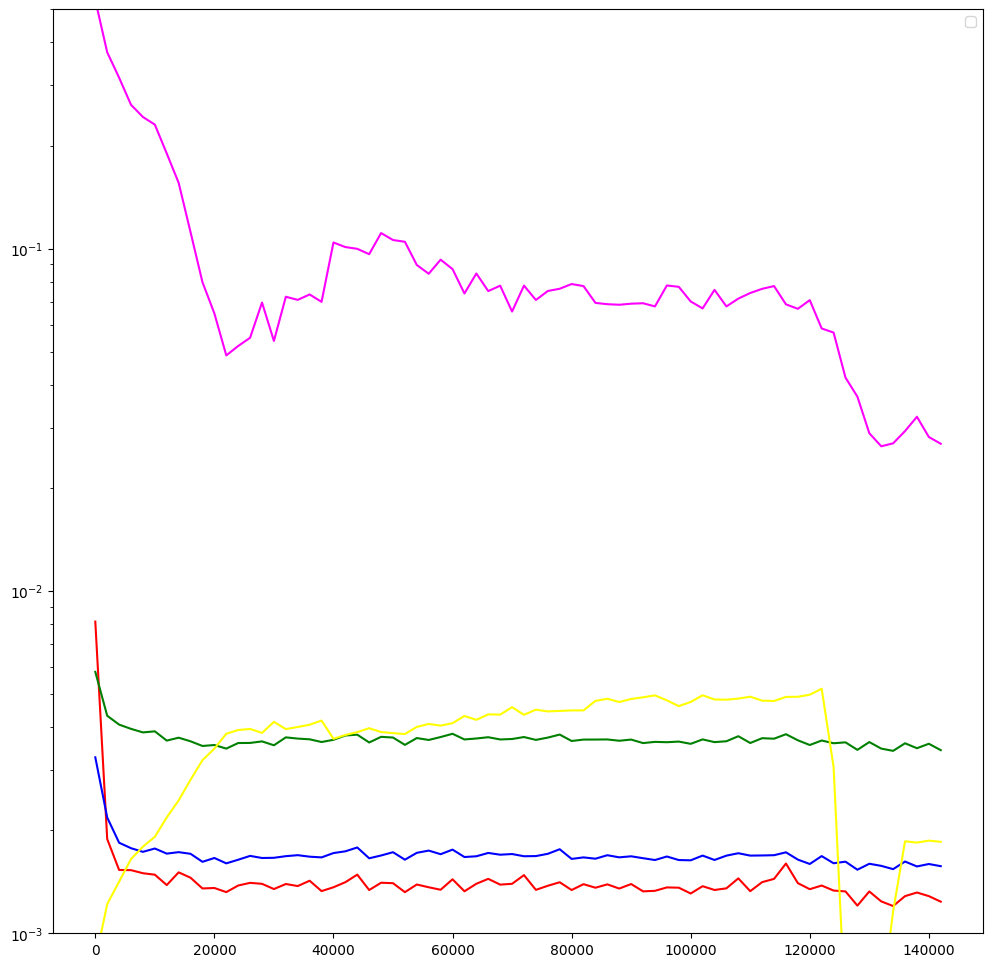

In [55]:
gan_helper.d_baseline.generator_weight = 0.0003
gan_helper.train(steps=10000, lr_g=0.000001 * b_m, lr_d=0.00001 * b_m)
show_plt(av=2000, y_min=0.001, y_max=0.5)

146000: [0.00126521 0.00351118 0.00157822 0.00183459 0.02759654]
147000: [0.00127962 0.00347028 0.00156722 0.00188752 0.02363338]
148000: [0.00134789 0.00363039 0.00165528 0.00195522 0.02284679]
149000: [0.00131847 0.0035546  0.00158725 0.00185934 0.0278338 ]
150000: [0.00121083 0.00350392 0.00160334 0.00189372 0.02667947]
151000: [0.00130155 0.00349675 0.00156462 0.00180522 0.03281102]
152000: [0.00125775 0.00350709 0.0015567  0.00187005 0.02414752]
153000: [0.00127735 0.00351022 0.00158023 0.00189633 0.0250684 ]
154000: [0.00119907 0.00343363 0.00156288 0.00191023 0.02081938]
155000: [0.00124701 0.00345481 0.00154414 0.00188158 0.02063498]
156000: [0.0012312  0.00344408 0.0015499  0.00183316 0.02752429]
157000: [0.00129093 0.00354804 0.00156752 0.00194433 0.02066307]
158000: [0.00130893 0.00359575 0.00161289 0.00195533 0.02323454]
159000: [0.00133866 0.00360157 0.00159086 0.00186612 0.0319116 ]
160000: [0.0012367  0.00337661 0.00149736 0.00188237 0.02571118]
161000: [0.0011403  0.003

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


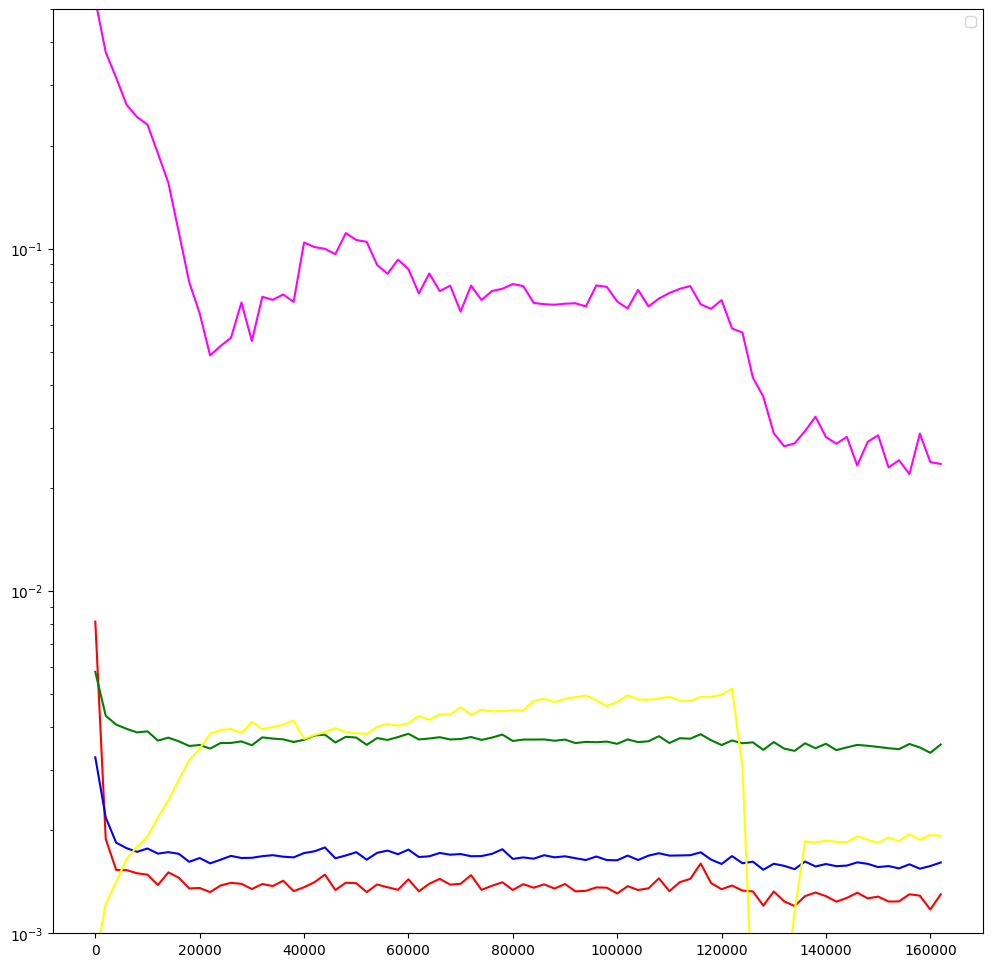

In [60]:
gan_helper.d_baseline.generator_weight = 0.0003
gan_helper.train(steps=20000, lr_g=0.000001 * b_m, lr_d=0.00001 * b_m)
show_plt(av=2000, y_min=0.001, y_max=0.5)

170000: [0.00126268 0.00350142 0.00159367 0.00196347 0.02198231]
180000: [0.00120346 0.00340803 0.00153375 0.00200983 0.0196597 ]
190000: [0.00119169 0.00341255 0.00155818 0.00206002 0.01573453]
200000: [0.00122545 0.00343129 0.00154228 0.0020989  0.01558694]
210000: [0.00123725 0.00345673 0.00156384 0.00211622 0.01418782]
220000: [0.00120211 0.00341286 0.00155416 0.00215619 0.013007  ]
230000: [0.0012376  0.00340474 0.00154591 0.00219443 0.01279663]
240000: [0.00126976 0.00346417 0.00156743 0.00221016 0.0126349 ]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


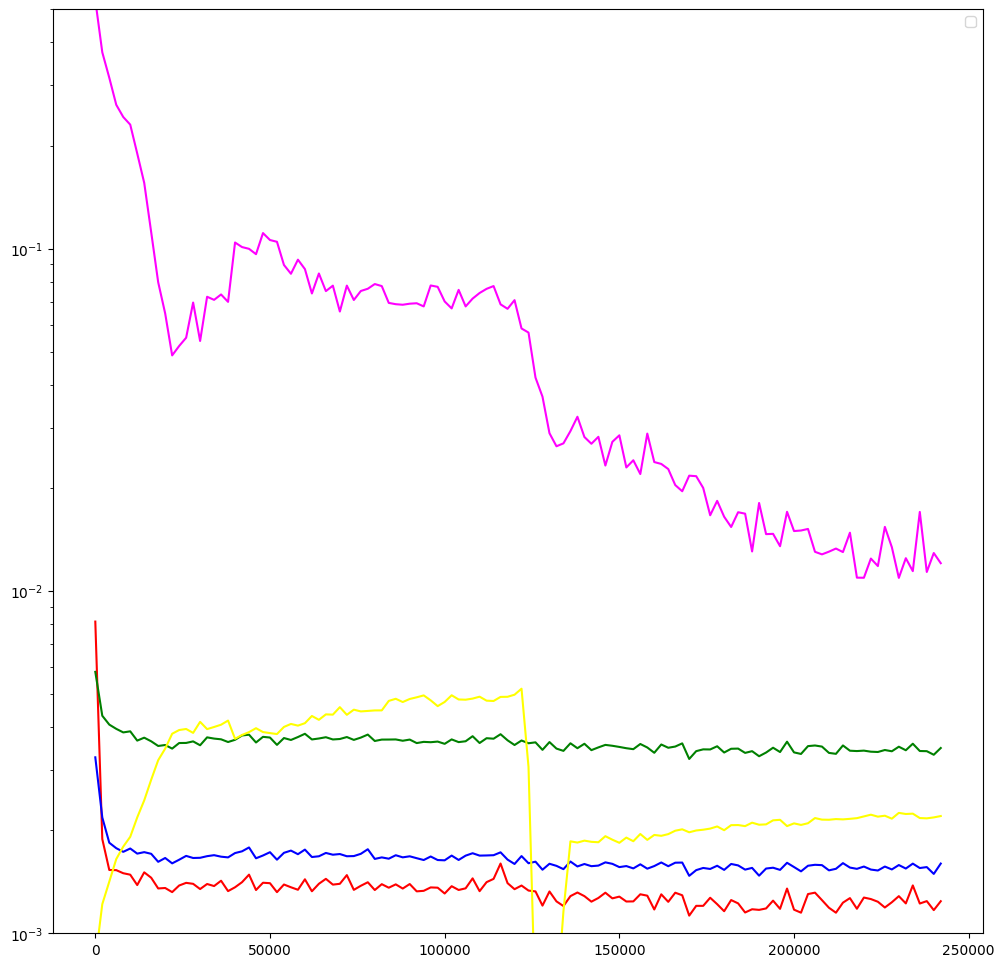

In [64]:
gan_helper.d_baseline.generator_weight = 0.0003
gan_helper.losses_print_step = 10000
gan_helper.train(steps=80000, lr_g=0.000001 * b_m, lr_d=0.00001 * b_m)
show_plt(av=2000, y_min=0.001, y_max=0.5)

In [74]:
gan_helper.d_baseline.generator_weight = 0.0003
gan_helper.losses_print_step = 1000
gan_helper.train(steps=10000, lr_g=0.000001 * b_m, lr_d=0.00001 * b_m)

247000: [0.00110847 0.00312298 0.00139464 0.00202081 0.01126466]
248000: [0.00129739 0.00349896 0.00156499 0.00231386 0.00874301]
249000: [0.00119392 0.00346274 0.00153773 0.00224892 0.01062049]
250000: [0.00130283 0.00351154 0.0015851  0.00221739 0.0104284 ]
251000: [0.00112173 0.00335431 0.00154691 0.00224093 0.01216701]
252000: [0.00113098 0.00333492 0.00150437 0.00221047 0.01080145]
253000: [0.00125547 0.00345253 0.00155097 0.002302   0.01039461]
254000: [0.00119266 0.00337166 0.00155722 0.00230459 0.01003595]
255000: [0.00120958 0.00344105 0.00158793 0.00228215 0.01221683]
256000: [0.00115776 0.00335496 0.00150069 0.00225934 0.01041081]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


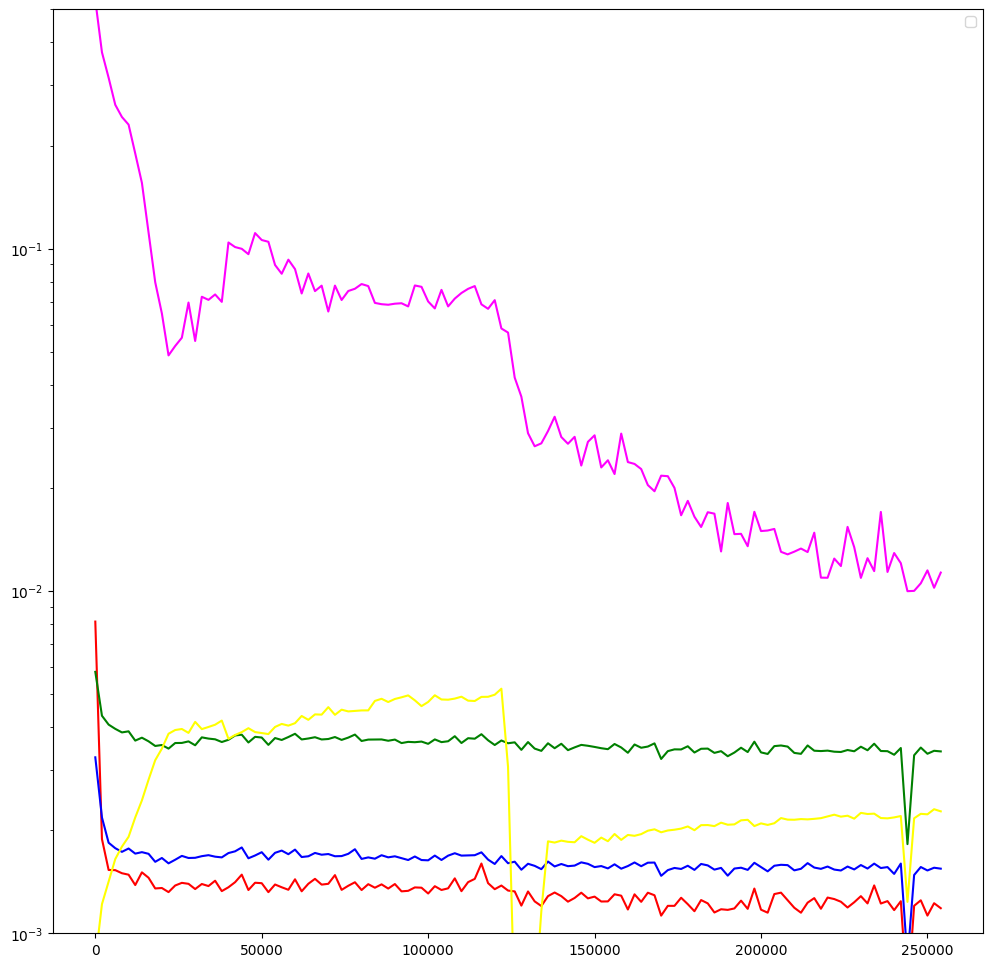

In [76]:
show_plt(av=2000, y_min=0.001, y_max=0.5)

In [77]:
gan_helper.d_baseline.generator_weight = 0.0003
gan_helper.losses_print_step = 1000
gan_helper.train(steps=10000, lr_g=0.0, lr_d=0.00001 * b_m)

257000: [0.00012076 0.00035648 0.00015896 0.00023975 0.0097142 ]
258000: [0.         0.         0.         0.         0.00976221]
259000: [0.         0.         0.         0.         0.01116735]
260000: [0.       0.       0.       0.       0.012437]
261000: [0.         0.         0.         0.         0.00828445]
262000: [0.         0.         0.         0.         0.00839634]
263000: [0.         0.         0.         0.         0.01146284]
264000: [0.         0.         0.         0.         0.00794287]
265000: [0.         0.         0.         0.         0.01024294]
266000: [0.         0.         0.         0.         0.00756159]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


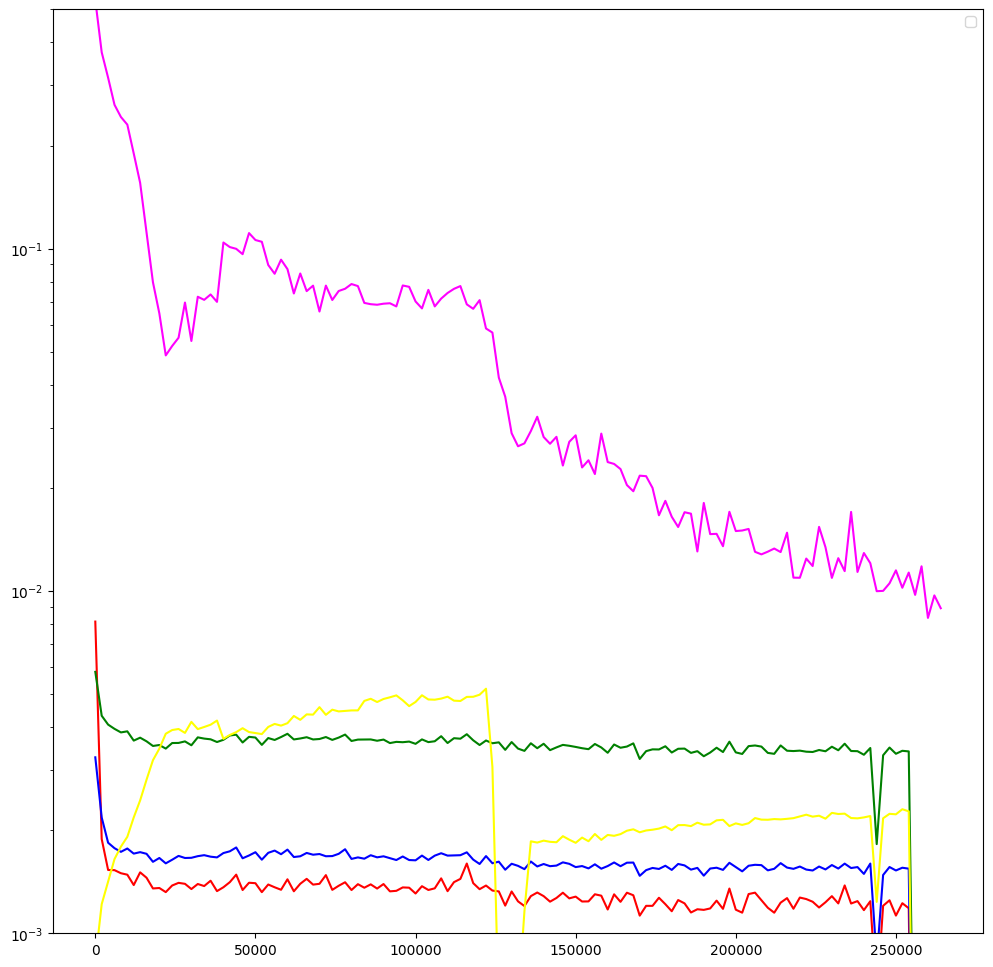

In [78]:
show_plt(av=2000, y_min=0.001, y_max=0.5)

In [79]:
gan_helper.d_baseline.generator_weight = 0.0003
gan_helper.losses_print_step = 1000
gan_helper.train(steps=40000, lr_g=0.0, lr_d=0.00001 * b_m)

267000: [0.         0.         0.         0.         0.00956828]
268000: [0.         0.         0.         0.         0.01047461]
269000: [0.         0.         0.         0.         0.01091094]
270000: [0.         0.         0.         0.         0.00867566]
271000: [0.         0.         0.         0.         0.00785456]
272000: [0.         0.         0.         0.         0.00950805]
273000: [0.         0.         0.         0.         0.00689418]
274000: [0.        0.        0.        0.        0.0070525]
275000: [0.         0.         0.         0.         0.00742801]
276000: [0.         0.         0.         0.         0.00729989]
277000: [0.         0.         0.         0.         0.00717676]
278000: [0.         0.         0.         0.         0.00987181]
279000: [0.         0.         0.         0.         0.01027031]
280000: [0.         0.         0.         0.         0.00715226]
281000: [0.         0.         0.         0.         0.00739752]
282000: [0.         0.        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


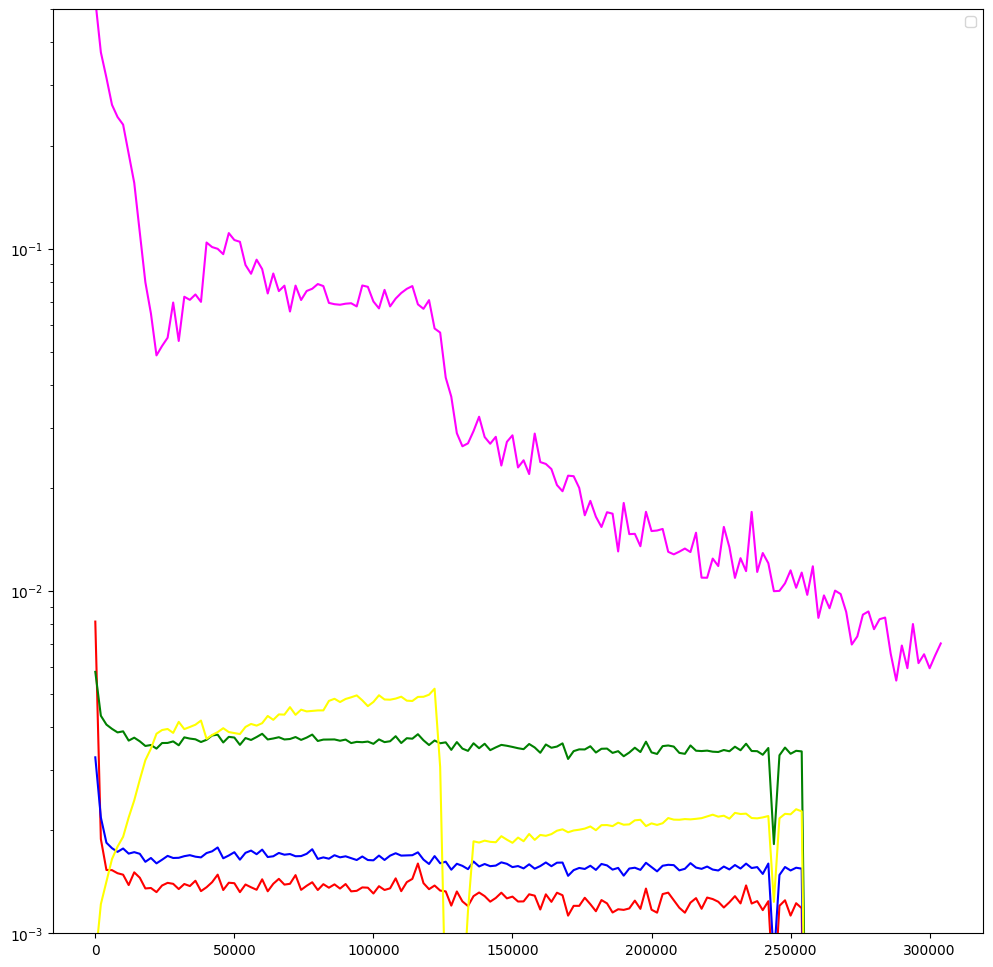

In [80]:
show_plt(av=2000, y_min=0.001, y_max=0.5)

In [81]:
gan_helper.d_baseline.generator_weight = 0.0003
gan_helper.losses_print_step = 1000
gan_helper.train(steps=40000, lr_g=0.000001, lr_d=0.00001 * b_m)

307000: [0.00108594 0.00310966 0.00139862 0.00212525 0.00918506]
308000: [0.00126467 0.00354193 0.0015776  0.00234975 0.01062902]
309000: [0.001126   0.00325924 0.00149491 0.00243878 0.00684664]
310000: [0.00120788 0.00344718 0.00160908 0.00235599 0.01268617]
311000: [0.00111795 0.0032586  0.00151456 0.00238532 0.00801437]
312000: [0.00127618 0.00344378 0.00155984 0.00233969 0.0139057 ]
313000: [0.00119652 0.00344065 0.00157349 0.00234382 0.01104156]
314000: [0.0012524  0.00341822 0.0015473  0.0023258  0.00886557]
315000: [0.00140748 0.00351377 0.00155551 0.00227025 0.01329005]
316000: [0.00128705 0.00349756 0.00157323 0.00234959 0.01115282]
317000: [0.00120247 0.00344118 0.00156309 0.00225806 0.01960166]
318000: [0.00137167 0.00348804 0.00159012 0.0021486  0.01566001]
319000: [0.00131138 0.0035667  0.00162046 0.0022465  0.0116314 ]
320000: [0.00137514 0.00369017 0.00160312 0.00226652 0.01584852]
321000: [0.00122085 0.00343166 0.00157391 0.00218148 0.02375786]
322000: [0.00115392 0.003

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


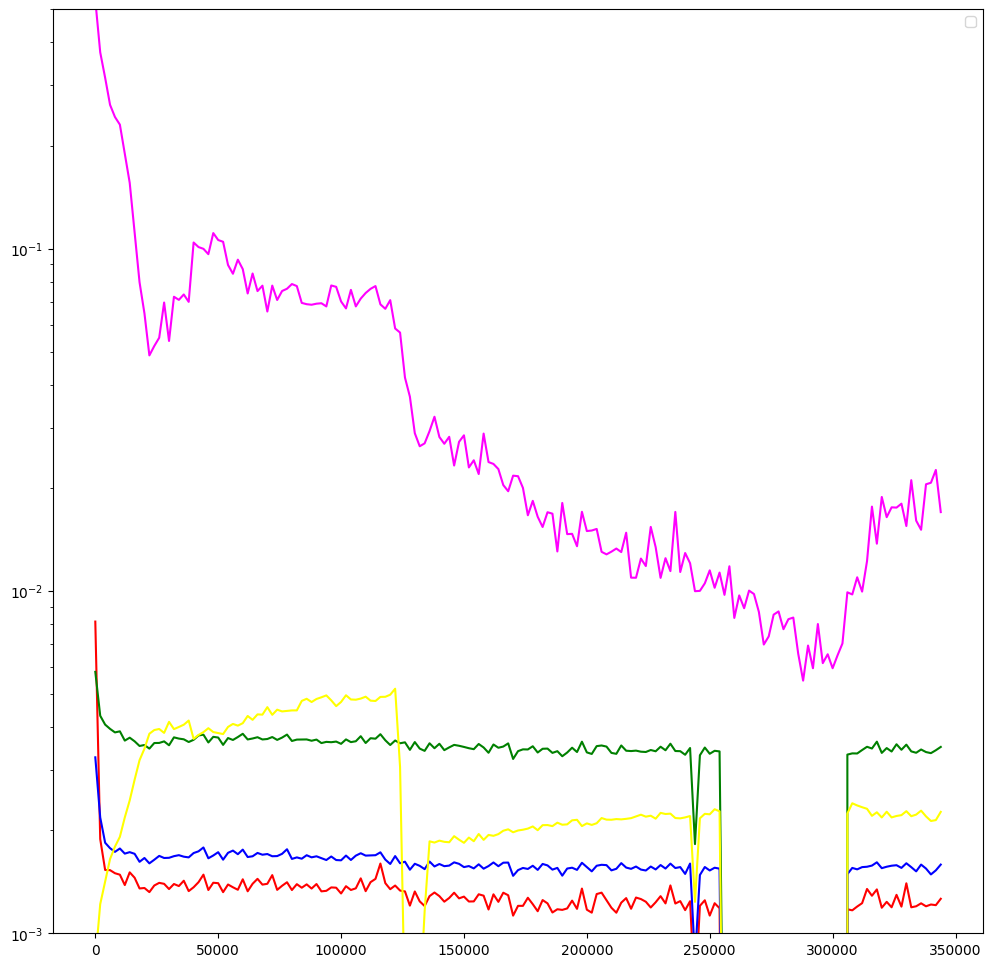

In [82]:
show_plt(av=2000, y_min=0.001, y_max=0.5)

In [83]:
model_suffix = gan_helper.save_model()
model_suffix

'2023-05-15-20-43-23'

347000: [0.00118309 0.00341895 0.00156339 0.00208002 0.02706956]
348000: [0.00121326 0.00337713 0.00153229 0.00216204 0.02097964]
349000: [0.00124276 0.00337402 0.00156195 0.00220246 0.02131962]
350000: [0.00137498 0.00360218 0.00162615 0.00223851 0.02327114]
351000: [0.00129557 0.00346721 0.00158346 0.00221714 0.01729675]
352000: [0.00117314 0.00335611 0.00152243 0.00225546 0.01517085]
353000: [0.00118415 0.00346736 0.00155696 0.00229942 0.01649067]
354000: [0.00133541 0.00350052 0.00154785 0.00228363 0.01571181]
355000: [0.00117435 0.00334211 0.00152887 0.00226552 0.02160552]
356000: [0.00121546 0.00343236 0.00156496 0.00224396 0.01962582]
357000: [0.00125768 0.00350115 0.00157577 0.00232694 0.01802532]
358000: [0.00135664 0.00350384 0.00159804 0.00223446 0.01783628]
359000: [0.00120767 0.00340747 0.00153849 0.00230618 0.01589693]
360000: [0.00129589 0.00350674 0.00157744 0.0022603  0.02059937]
361000: [0.00116452 0.00337813 0.00156028 0.00227352 0.02029353]
362000: [0.00125095 0.003

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


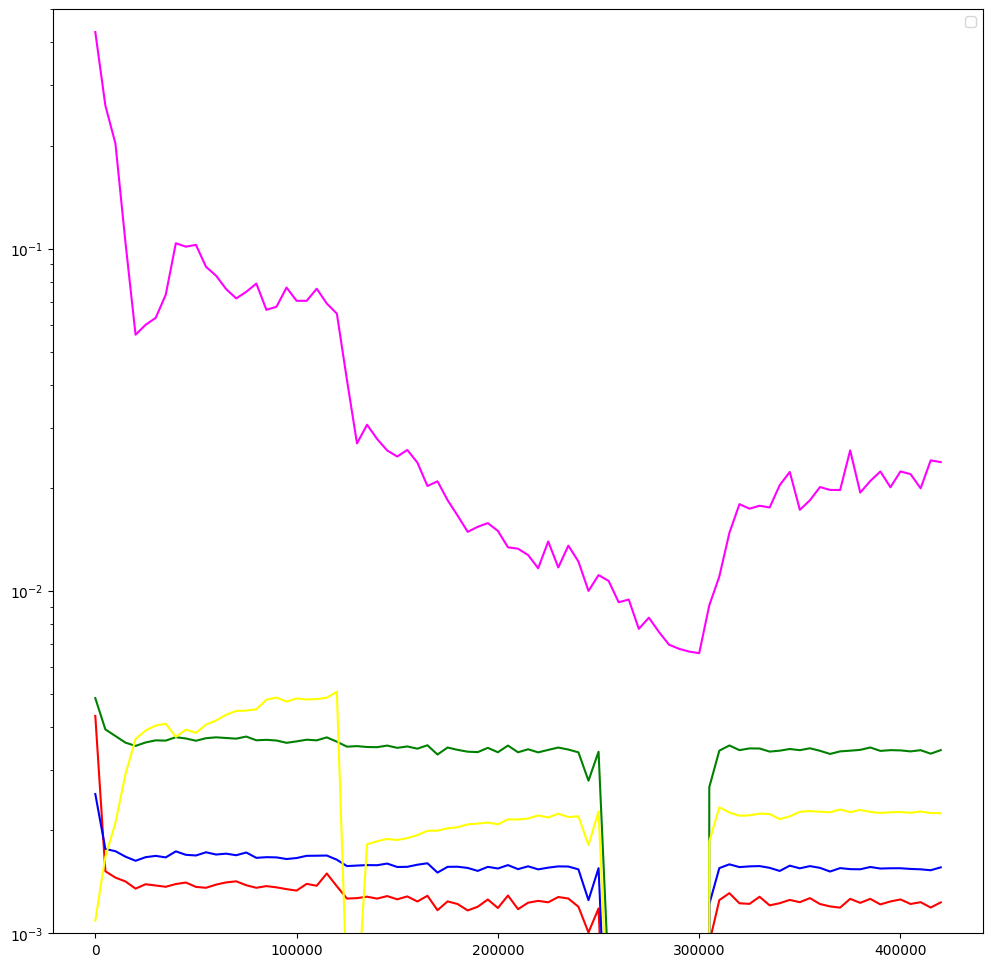

In [90]:
gan_helper.d_baseline.generator_weight = 0.0003
gan_helper.losses_print_step = 1000
gan_helper.train(steps=80000, lr_g=0.0000003, lr_d=0.000003 * b_m)
show_plt(av=5000, y_min=0.001, y_max=0.5)

In [91]:
model_suffix = gan_helper.save_model()
model_suffix

'2023-05-16-08-56-01'

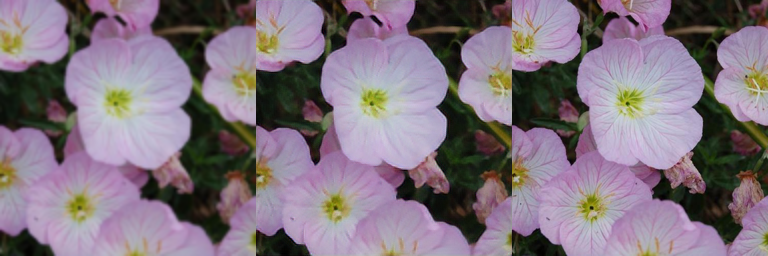

In [93]:
gan_helper.demonstrate(dataset[0])

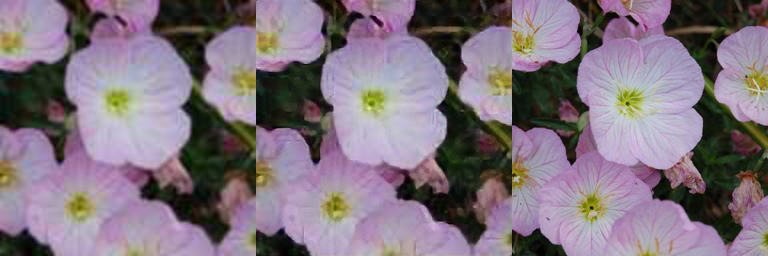

In [94]:
gan_helper.demonstrate(dataset[0], jpeger_no=0)

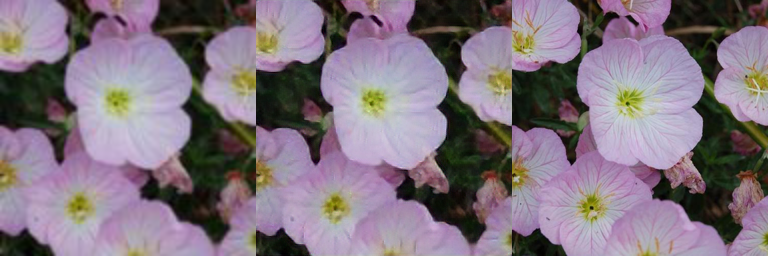

In [95]:
gan_helper.demonstrate(dataset[0], jpeger_no=2)

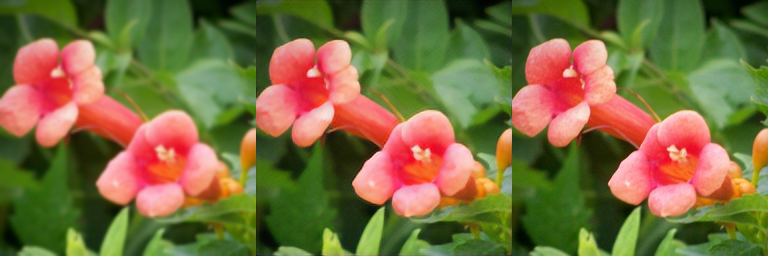

In [96]:
gan_helper.demonstrate(dataset[6])

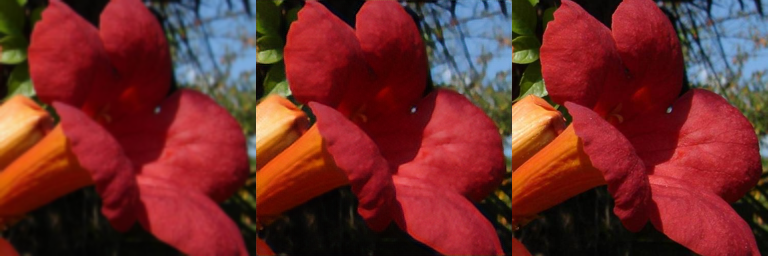

In [97]:
gan_helper.demonstrate(dataset[7])

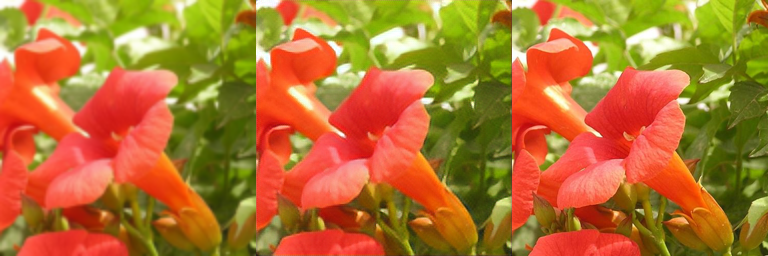

In [98]:
gan_helper.demonstrate(dataset[8])

In [102]:
g = GeneratorRRDBx2(channels=64, num_res_blocks=16)
g.load_state_dict(torch.load(f"models/espcn/generator_espcn_{model_suffix}.pth"))
g.to('cuda')

saver = pyml.ImageSaver(f'/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/{model_suffix}-pics')

demo_data = pyml.ImagesDataset.from_dirs_recursive(
    roots=["/mnt/pi8-v2/mnt/safedata/datasets/2020/torrent/windows"],
    shuffle_seed=12,
    channels_order='chw'
)

for i in range(500):
    src = demo_data[i]
    if src is None:
        continue
    if src.shape[1] > 1280 or src.shape[2] > 1280:
        continue

    batch = torch.from_numpy(src[np.newaxis])
    with torch.no_grad():
        y = g(batch.to('cuda')).cpu()
    saver.saveCHW(src)
    saver.saveCHW(y.detach().numpy()[0])
    print(".", end='.')

..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [103]:
import PIL.ImageOps

saver2 = pyml.ImageSaver(f'/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/{model_suffix}-pics-l')

for i in range(1000):
    src = demo_data[i]
    if src is None:
        continue
    if src.shape[1] <= 1280 and src.shape[2] <= 1280:
        continue
    pil_image = PILImage.open(demo_data.images_paths[i])
    pil_image = PIL.ImageOps.exif_transpose(pil_image)
    pil_image = pil_image.convert('RGB')
    w, h = pil_image.size
    k = 512.0 / max(h, w)
    pil_image = pil_image.resize(size=(int(w * k), int(h * k)))

    np_array = np.asarray(pil_image).astype(np.float32) / 255.0
    np_array = np.moveaxis(np_array, 2, 0)

    batch = torch.from_numpy(np_array[np.newaxis])
    with torch.no_grad():
        y = g(batch.to('cuda')).cpu()
    saver2.saveCHW(np_array)
    saver2.saveCHW(y.detach().numpy()[0])
    print(".", end='.')

..................................................................................................................................................................................................................................................................................................................................................................................................

In [21]:
data = pyml.ImagesDataset.from_dirs_recursive(
    roots=["/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples"],
    channels_order='chw'
)
data.images_paths

['/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210507_195012.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210507_200212.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210524_100644(0).jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210524_100941.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210526_133529.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210527_145012.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210604_100509.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210605_232353.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210621_140736.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210621_140740.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/IMG_0280.JPG',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural 

In [92]:
g = GeneratorRRDBx2(channels=64, num_res_blocks=16)
g.load_state_dict(torch.load(f"models/espcn/generator_espcn_{model_suffix}.pth"))
g.eval().to('cuda')

print(f"model_suffix = {model_suffix}")

saver = pyml.ImageSaver(f'/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/{model_suffix}-demo')

def demo(src: np.ndarray):
    with torch.no_grad():
        batch = torch.from_numpy(src[np.newaxis]).to('cuda')
    
        while batch.size(2) > 512 or batch.size(3) > 512:
            batch = gan_helper.downsample(batch, 2)
    
        saver.saveCHW(batch.detach().cpu().numpy()[0], name_prefix='src_')
        print(f"src saved: batch.size() = {batch.size()}")
        while batch.size(2) <= 1024 or batch.size(3) <= 1024:
            batch = g(batch)
            saver.saveCHW(batch.detach().cpu().numpy()[0])
            print(f"saved: batch.size() = {batch.size()}")
    
for pic in data:
    demo(pic)
    
g = None

model_suffix = 2023-05-16-08-56-01
src saved: batch.size() = torch.Size([1, 3, 504, 378])
saved: batch.size() = torch.Size([1, 3, 1008, 756])
saved: batch.size() = torch.Size([1, 3, 2016, 1512])
src saved: batch.size() = torch.Size([1, 3, 378, 504])
saved: batch.size() = torch.Size([1, 3, 756, 1008])
saved: batch.size() = torch.Size([1, 3, 1512, 2016])
src saved: batch.size() = torch.Size([1, 3, 378, 504])
saved: batch.size() = torch.Size([1, 3, 756, 1008])
saved: batch.size() = torch.Size([1, 3, 1512, 2016])
src saved: batch.size() = torch.Size([1, 3, 378, 504])
saved: batch.size() = torch.Size([1, 3, 756, 1008])
saved: batch.size() = torch.Size([1, 3, 1512, 2016])
src saved: batch.size() = torch.Size([1, 3, 378, 504])
saved: batch.size() = torch.Size([1, 3, 756, 1008])
saved: batch.size() = torch.Size([1, 3, 1512, 2016])
src saved: batch.size() = torch.Size([1, 3, 378, 504])
saved: batch.size() = torch.Size([1, 3, 756, 1008])
saved: batch.size() = torch.Size([1, 3, 1512, 2016])
src s